# Pobranie danych

In [ ]:
!pip install wget
import wget
import zipfile

url = 'https://files.grouplens.org/datasets/movielens/ml-latest.zip'

wget.download(url)
with zipfile.ZipFile('ml-latest.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Wstępna analiza 

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["figure.figsize"] = (20,5)

import cpi

import datetime

# cpi.update()


In [ ]:
dir = './ml-latest/'

movies = pd.read_csv(dir + 'movies.csv')
ratings = pd.read_csv(dir + 'ratings.csv')
tags = pd.read_csv(dir + 'tags.csv')

Zbiór zawiera 27753444 ocen i 1108997 przypisań tagów do 58098 filmów. Dane te zostały utworzone przez 283228 użytkowników między 09 stycznia 1995 r., a 26 września 2018 r. Zbiór danych został wygenerowany 26 września 2018 roku i pochodzi z serwisu, którego użytkownicy oceniali filmy w celu pobrania rekomendacji.

Pliki, które będą najbardziej przydatne w naszym problemie:
* ratings.csv - zawiera userId,movieId,rating,timestamp czyli oceny nadane przez użytkowników dla poszczególnych filmów w skali 1-5
* tags.csv - przypisania tagów do filmów
* movies.csv - informacje o filmach, przypisanie gatunków do filmu
* links.csv - odnośniki do filmów w popularnych serwisach
* pliki genome - współczynniki w jakim stopniu dany film odwzwierciedla dany gatunek/tag

Do naszego problemu najbardziej przyda się ratings.csv, movies.csv i tags.csv.

## Co zawierają zbiory?

### Tags.csv

In [ ]:
tags.head(10)

,userId,movieId,tag,timestamp
0,14,110,epic,1443148538
1,14,110,Medieval,1443148532
2,14,260,sci-fi,1442169410
3,14,260,space action,1442169421
4,14,318,imdb top 250,1442615195
5,14,318,justice,1442615192
6,14,480,Dinosaurs,1443148563
7,14,593,psychothriller,1444014286
8,14,1682,philosophy,1442615158
9,14,1682,surveillance,1442615167


#### Rozkład tagów


In [ ]:
len(tags.index)

1108997

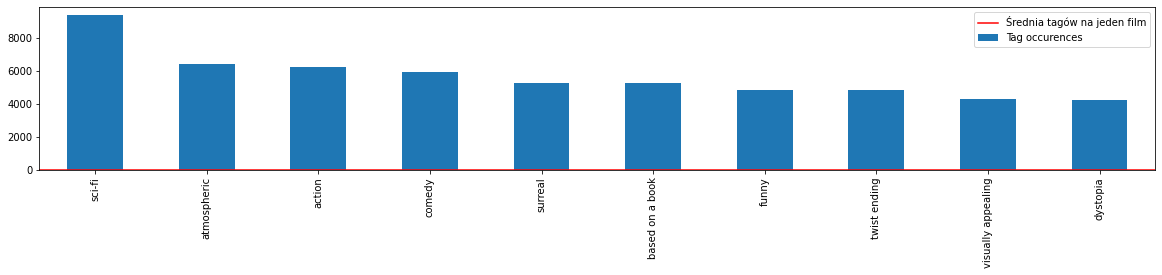

In [ ]:
ax = tags['tag'].value_counts().nlargest(10).plot(kind='bar', label="Tag occurences")

avg = tags['tag'].value_counts().sum()/len(tags['tag'].value_counts())

ax.axhline(avg, color='red', label="Średnia tagów na jeden film")
ax.legend(loc='upper right')

### Movies.csv

In [ ]:
movies.head(10)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


#### Rozkład gatunków

In [ ]:
# W celach wizulizacji wybierzemy gatunek z indeksu 0 jako gatunek główny

movies['main_genre'] = movies['genres'].apply(lambda x: x.split('|')[0] if len(x.split('|')) > 0 else None)

<AxesSubplot:>

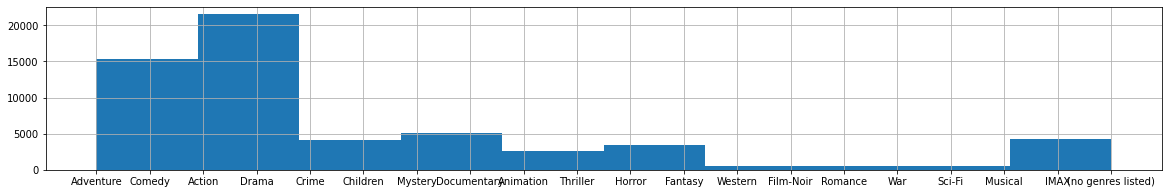

In [ ]:
movies['main_genre'].hist()

### Ratings.csv

In [ ]:
ratings.head(10)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471
3,1,1257,4.5,1256677460
4,1,1449,4.5,1256677264
5,1,1590,2.5,1256677236
6,1,1591,1.5,1256677475
7,1,2134,4.5,1256677464
8,1,2478,4.0,1256677239
9,1,2840,3.0,1256677500


#### Rozkład ocen

<AxesSubplot:>

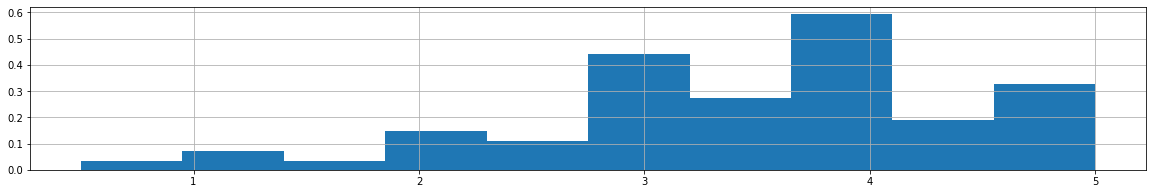

In [ ]:
ratings["rating"].hist(density=True)

#### Współczynnik skośności i średnia ocena

In [ ]:
ratings["rating"].skew(), ratings["rating"].mean()


(-0.6976173841363082, 3.5304452124932677)

#### Ilość ocen na film

Text(0, 0.5, 'Ilość ocen')

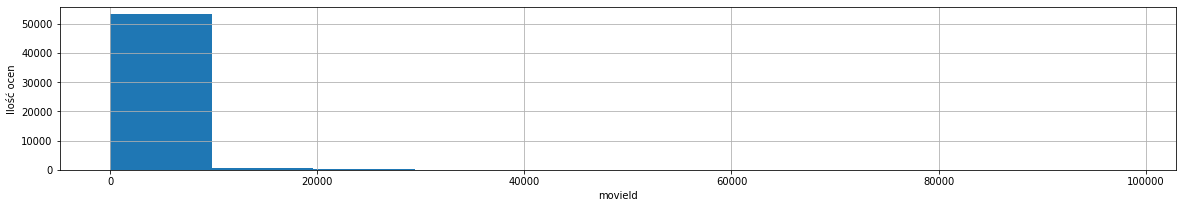

In [ ]:
ax = ratings[['movieId']].value_counts().hist()
ax.set_xlabel('movieId')
ax.set_ylabel('Ilość ocen')

#### Rozkład ocen wg. gatunku

In [ ]:
boxplot_df = ratings.merge(movies[['movieId', 'main_genre']],  how='left', on='movieId')

Text(0, 0.5, 'Rating')

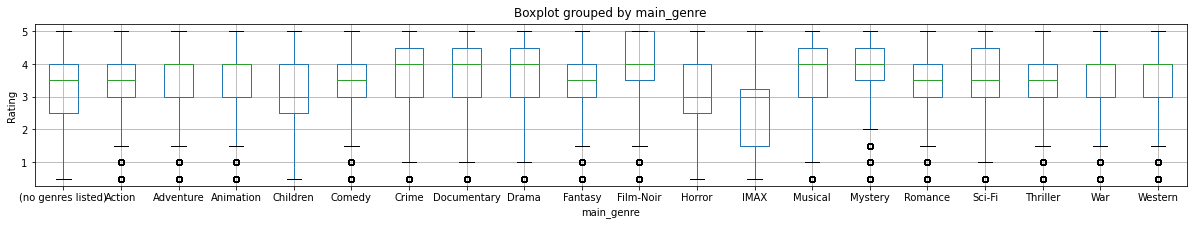

In [ ]:
ax = boxplot_df.boxplot(column=['rating'], by='main_genre')
ax.set_title("")
ax.set_ylabel("Rating")

#### Średnia ilość ocen na film

In [ ]:
ratings['movieId'].value_counts().mean()

515.0113010076268

## Podsumowanie

W zbiorze `movies` kolumna `genres` to lista gatunków i nie jest znormalizowana - w kolumnie przechowywana jest lista. Nie ma powodu normalizować tej kolumny ponieważ:
  * nie ma wiarygodnej metody na wybranie z listy gatunku wodzącego (najbardziej pasującego) (zrobić to losowo czy posortowac alfabetycznie?)
  * na etapie przygotowywania danych gatunki i tak zostaną zakodowane w przestrzeni jako wektor

Na cele wizulizacji po prostu obieramy gatunek z indeksu 0 jako gatunek główny.

Średnio każdy film ma przypisane 5 tagów, podczas gdy cały zbiór przypisań ma 1108997 elementów na 58098. Z wykresu można wywniskować, że w tym zbiorze jest dużo outlierów - nie jest to zaskoczenie ponieważ tagi to są frazy definiowane przez użytkowników i nieustandaryzowane w żaden sposób - zatem każdy mógł przypisać do filmu co chciał.

Wykres dystrybucji ocen przypomina rozkład normalny, z tym, że jest to rozkład lewostronnie skośny. Współczynnik skośności wynosi -0.69.

## Proponowane modele

1. Content-based filtering: Ta metoda rekomenduje pozycje na podstawie podobieństwa między cechami pozycji a preferencjami użytkownika. Filtrowanie oparte na treści może być stosowane, gdy istnieje wystarczająca ilość danych o cechach przedmiotu i preferencjach użytkownika.
  * możliwe implementacje:
    * zakodowanie gatunków, tagów i innych cech, które uznamy za stosowne, do wektora, po czym dobranie rekomdendacji na podstawie dobranej metryki, np. Cosine similarity
    * j/w tylko użycie opisów dot. filmu z bazy danych np. IMDB
  * użytkownik wybiera np. 5 filmów, które mu się podobają i otrzymuje rekomendacje
  * bez użycia sieci neuronowych
2. Collaborative filtering: Metoda ta rekomenduje pozycje na podstawie podobieństwa pomiędzy przeszłymi zachowaniami i preferencjami użytkowników. 
  * czyli rekomendacje są opracowywane na podstawie co lubią oglądać użytkownicy z profilem podobnym do nas
  * możliwe implementacje:
    * matrix factorization (https://surprise.readthedocs.io/en/stable/matrix_factorization.html)
    * 𝑘-nearest neighbor methods
    * generalnie trudniejsze i trzeba więcej poczytac
3. Metody hybrydowe łączące 1 i 2

### Todo 
  * przed spotkaniem:
    * dokonać jakiejs wizulizacji w przestrzeni
      * zredukować to przez PCA/TSNE i narysować wykres 2d/3d
  * ogółem:

    * połączyć datasety w jeden (meta dane z resztą itd)
    * wybrać metody i metryki do liczenia podobienstwa miedzy filmami

In [ ]:
ratings['movieId']

0             307
1             481
2            1091
3            1257
4            1449
            ...  
27753439     8542
27753440     8712
27753441    34405
27753442    44761
27753443    54286
Name: movieId, Length: 27753444, dtype: int64

In [ ]:
tags.groupby(by='movieId')['tag'].apply(list)

movieId
1         [animated, buddy movie, Cartoon, cgi, comedy, ...
2         [fantasy, adapted from:book, animals, bad cgi,...
3         [moldy, old, Ann Margaret, Burgess Meredith, D...
4         [characters, girl movie, characters, chick fli...
5         [steve martin, steve martin, pregnancy, remake...
                                ...                        
193761    [concert, hostage, kidnapping, opera singer, r...
193811                          [doppelganger, Julie Delpy]
193837           [aliens, anime, cat, space marines, virus]
193864    [Alfredo Landa, anticonception, comic, family,...
193868    [black and white, comedy, friendship, fun, mar...
Name: tag, Length: 45981, dtype: object

In [ ]:
grouped = tags.groupby(by='movieId')['tag'].apply(list).reset_index(name='new')

grouped

,movieId,new
0,1,"[animated, buddy movie, Cartoon, cgi, comedy, ..."
1,2,"[fantasy, adapted from:book, animals, bad cgi,..."
2,3,"[moldy, old, Ann Margaret, Burgess Meredith, D..."
3,4,"[characters, girl movie, characters, chick fli..."
4,5,"[steve martin, steve martin, pregnancy, remake..."
...,...,...
45976,193761,"[concert, hostage, kidnapping, opera singer, r..."
45977,193811,"[doppelganger, Julie Delpy]"
45978,193837,"[aliens, anime, cat, space marines, virus]"
45979,193864,"[Alfredo Landa, anticonception, comic, family,..."


In [ ]:
movies_tag_merged = movies.merge(grouped, how='left', on='movieId')

movies

,movieId,title,genres,main_genre
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,Adventure
1,2,Jumanji (1995),Adventure|Children|Fantasy,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,Comedy
4,5,Father of the Bride Part II (1995),Comedy,Comedy
...,...,...,...,...
58093,193876,The Great Glinka (1946),(no genres listed),(no genres listed)
58094,193878,Les tribulations d'une caissière (2011),Comedy,Comedy
58095,193880,Her Name Was Mumu (2016),Drama,Drama
58096,193882,Flora (2017),Adventure|Drama|Horror|Sci-Fi,Adventure


In [ ]:
def split_genres(text):
  if text == '(no genres listed)':
    return []

  return text.split("|")

movies_tag_merged['genres'] = movies_tag_merged['genres'].apply(split_genres)

movies_tag_merged['new'] = movies_tag_merged['new'].apply(lambda d: d if isinstance(d, list) else [])

In [ ]:
movies_tag_merged['combined'] = movies_tag_merged['genres'] + movies_tag_merged['new']

In [ ]:
movies_tag_merged['combined'] = movies_tag_merged['combined'].astype('str')

In [ ]:
def clean(text):
  new_text = ''
  for x in text:
    if x != '[' and x != ']' and x != ',' and x != "'":
      new_text += x

  return new_text 
movies_tag_merged['combined'] = movies_tag_merged['combined'].apply(clean)

In [ ]:
movies_tag_merged['combined'] 

0        Adventure Animation Children Comedy Fantasy an...
1        Adventure Children Fantasy fantasy adapted fro...
2        Comedy Romance moldy old Ann Margaret Burgess ...
3        Comedy Drama Romance characters girl movie cha...
4        Comedy steve martin steve martin pregnancy rem...
                               ...                        
58093                                                     
58094                                               Comedy
58095                                                Drama
58096                        Adventure Drama Horror Sci-Fi
58097                                   Action Crime Drama
Name: combined, Length: 58098, dtype: object

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect = TfidfVectorizer(analyzer='word', stop_words='english', min_df = 1, ngram_range = (1, 2))

X = vect.fit_transform(movies_tag_merged['combined'])

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
from sklearn.decomposition import TruncatedSVD

pca = TruncatedSVD(n_components=2)

X_red = pca.fit_transform(X)

In [ ]:
genres = movies_tag_merged['main_genre'].unique().tolist()

In [ ]:
genres

['Adventure',
 'Comedy',
 'Action',
 'Drama',
 'Crime',
 'Children',
 'Mystery',
 'Documentary',
 'Animation',
 'Thriller',
 'Horror',
 'Fantasy',
 'Western',
 'Film-Noir',
 'Romance',
 'War',
 'Sci-Fi',
 'Musical',
 'IMAX',
 '(no genres listed)']

In [ ]:
movies_tag_merged['x'] = X_red[:,0]
movies_tag_merged['y'] = X_red[:,1]

In [ ]:
scatter_df = movies_tag_merged[movies_tag_merged['main_genre'] != None]

## Wizualizacja zbioru w przestrzeni

Łączymy listę gatunków i przypisanych tagów dla danego filmu w jeden tekst. Następnie dokonujemy wektoryzacji TF-IDF.

Po redukcji wymiarów tworzony jest poniższy wykres. Obrana metryka jest dyskusyjna i nie ma jednego poprawnego sposobu, ale na poniższym wykresie można zauważyć, że łatwo można wyróżnić dwie grupy filmów - family-friendly (children, comedy) oraz kino dla starszych (action, drama, horror).


In [ ]:
import plotly.express as px

px.scatter(scatter_df[:10000], x='x', y='y', color='main_genre', opacity=.5)

# Średnie oceny filmu na rok

In [128]:
from models.Movie import Movie
from sqlalchemy.orm import Session
from db import Connection

connection = Connection()
with Session(connection.engine) as session:
    movie = session.query(Movie).first()
    print(movie.name)
    ratings = movie.ratings


Toy Story (1995)


<Axes: title={'center': 'Average rating per year for Toy Story (1995)'}, xlabel='year'>

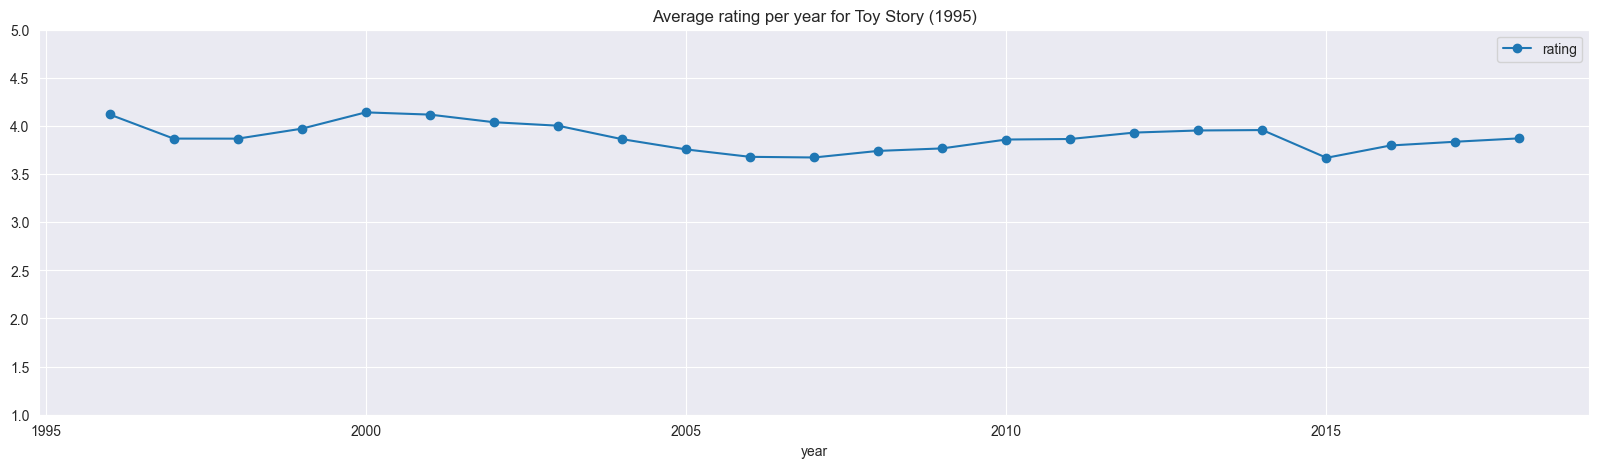

In [131]:
res = map(
        lambda r: (datetime.datetime.fromtimestamp(int(r.timestamp)).year, r.rating),
        ratings
    )

ratings_per_movie_df = pd.DataFrame(res, columns = ['year', 'rating'])
ratings_per_movie_df['year'] = ratings_per_movie_df['year'].astype(int)
ratings_per_movie_df.groupby(['year']).mean().plot(title='Average rating per year for %s' % movie.name, marker='o', yticks=[i for i in np.arange(1.0, 5.5, 0.5)])

# Analiza budżetu

In [80]:
df = pd.read_csv('movies_metadata.csv')
df.columns

/var/folders/ns/4jwbvxqn21xff084mf1vnt340000gn/T/ipykernel_72085/2697914182.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('movies_metadata.csv')


Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [81]:
from numpy import NaN
from datetime import datetime
df['release_year'] = list(
  map(
    lambda date: datetime.fromisoformat(date).year if type(date) is str and len(date) > 6 else NaN,
    df['release_date']
  )
)

In [82]:
df['budget']

0        30000000
1        65000000
2               0
3        16000000
4               0
           ...   
45461           0
45462           0
45463           0
45464           0
45465           0
Name: budget, Length: 45466, dtype: object

In [83]:
df = df.dropna()
df['budget'] = df['budget'].astype(int)
df = df[df['budget'] > 0.0]
df.reset_index(drop=True, inplace=True)

In [84]:
df[['budget', 'release_year']]

,budget,release_year
0,58000000,1995.0
1,3500000,1995.0
2,19000000,1996.0
3,2000000,1995.0
4,15000000,1995.0
...,...,...
513,175000000,2017.0
514,80000000,2017.0
515,152000000,2017.0
516,16000000,2000.0


In [85]:
df['adjusted_budget'] = list(
  map(
    lambda budget_year: cpi.inflate(budget_year[0], int(budget_year[1])),
    zip(df['budget'], df['release_year'])
  )
)




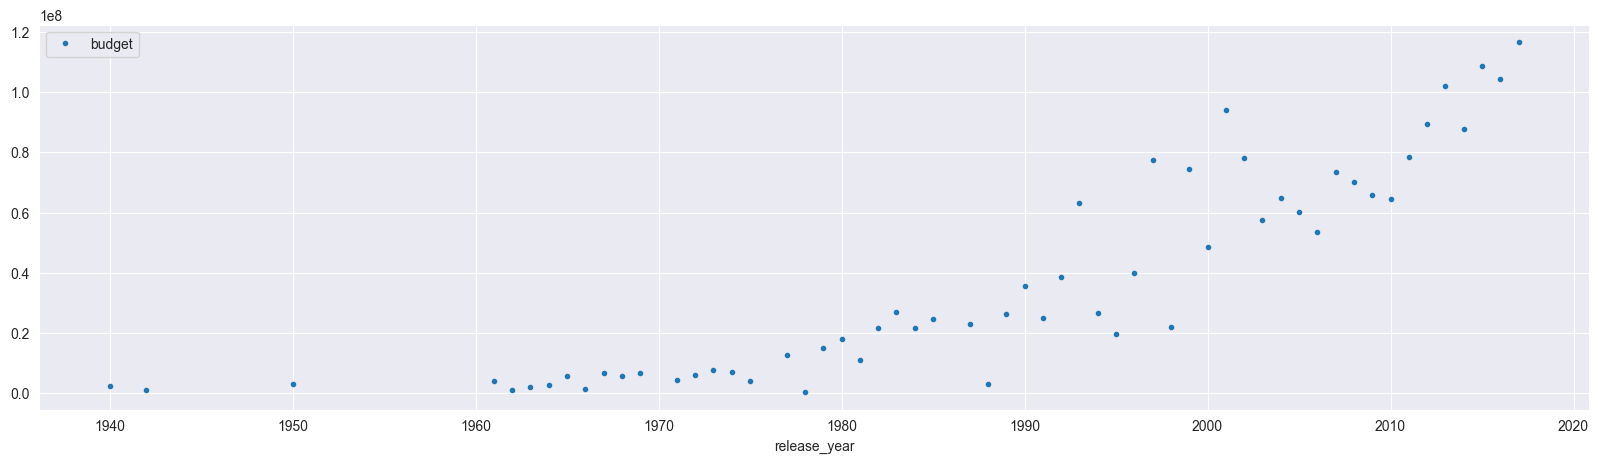

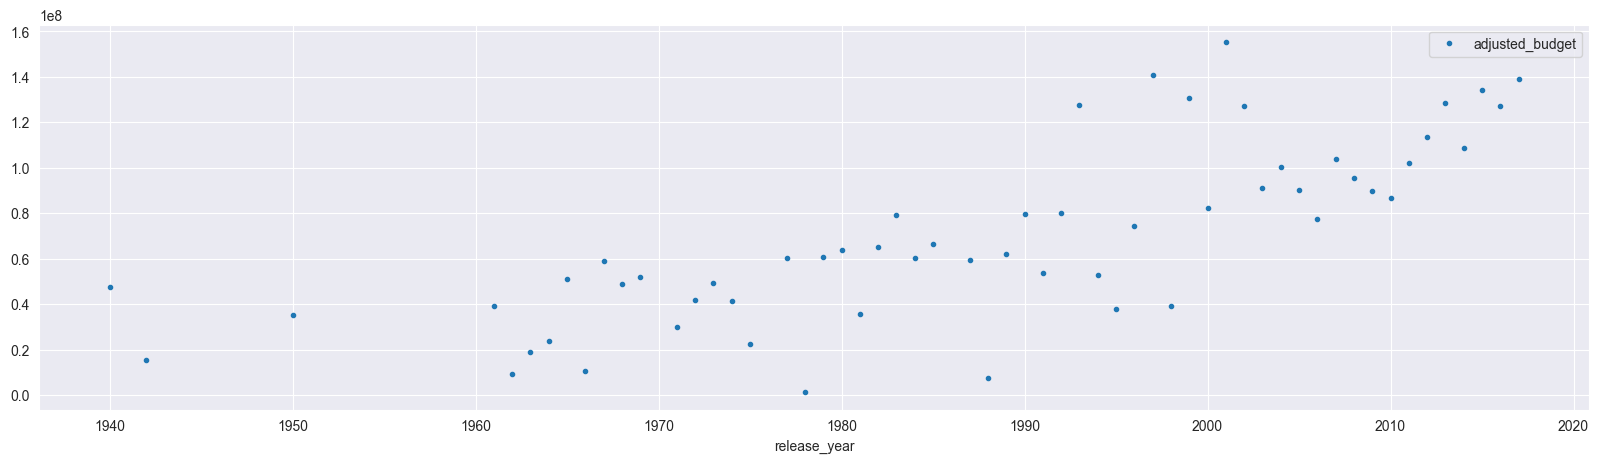

In [86]:
ax = average_budget_per_year = df[['release_year', 'budget']].groupby('release_year').mean().plot(style='.')
ax_adjusted = df[['release_year', 'adjusted_budget']].groupby(['release_year']).mean().plot(style='.')

# Box office

In [87]:
df['revenue'] = df['revenue'].astype(int)
df = df[df['revenue'] > 0.0]
df['revenue_adjusted'] = list(
  map(
    lambda revenue_year: cpi.inflate(revenue_year[0], int(revenue_year[1])),
    zip(df['revenue'], df['release_year'])
  )
)

<Axes: xlabel='release_year'>

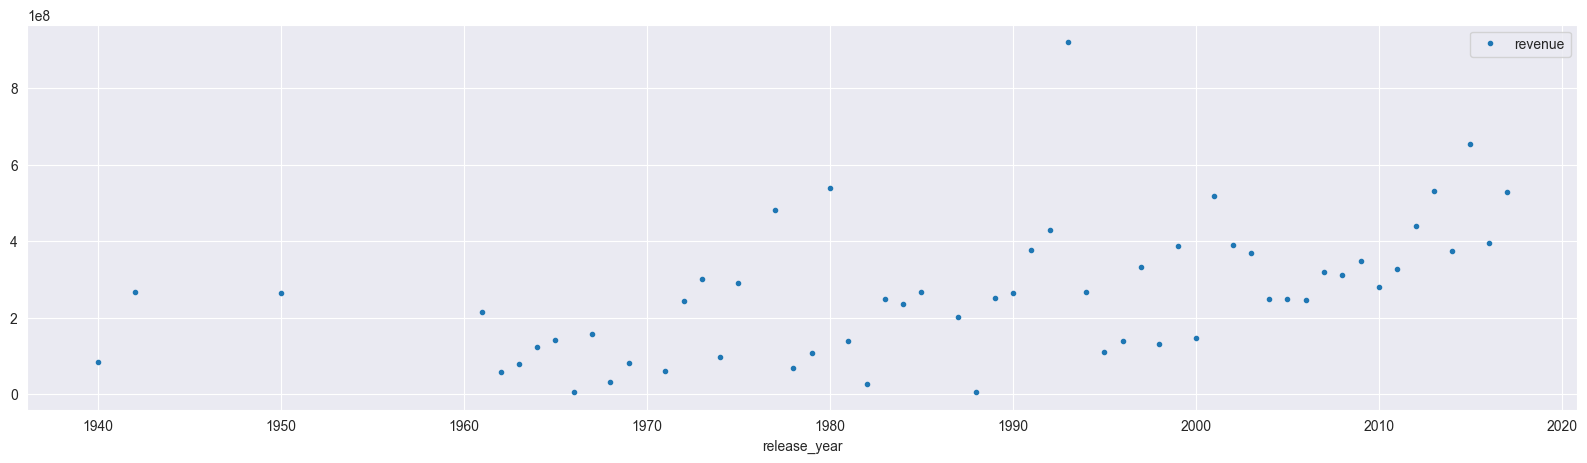

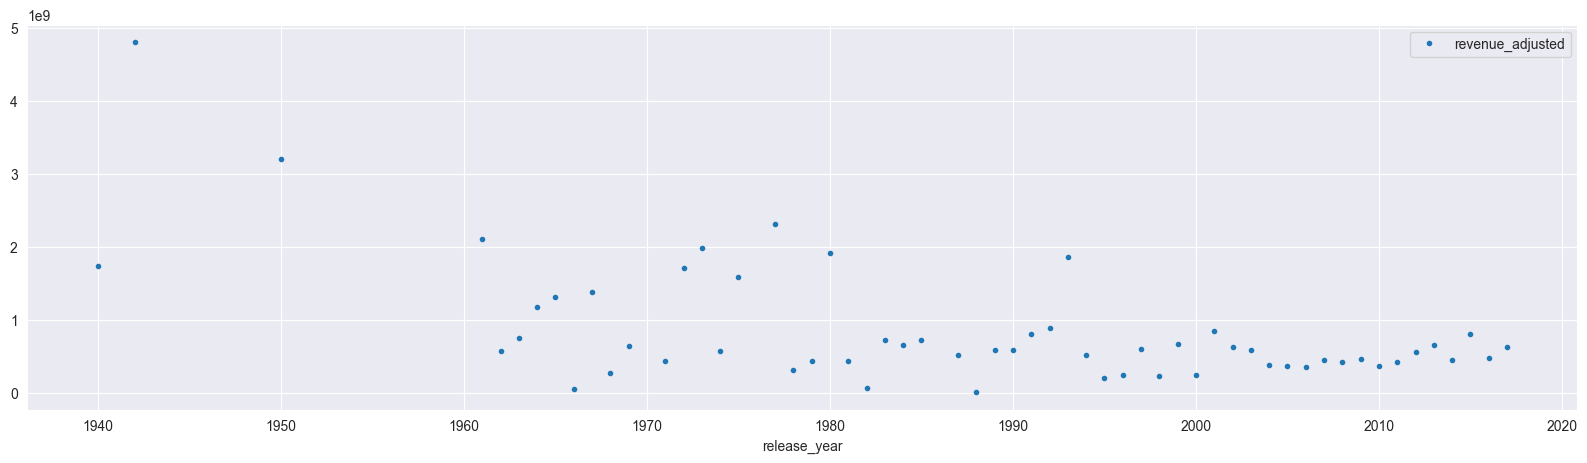

In [88]:
df[['release_year', 'revenue']].groupby('release_year').mean().plot(style='.')
df[['release_year', 'revenue_adjusted']].groupby(['release_year']).mean().plot(style='.')

In [89]:
df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year,adjusted_budget,revenue_adjusted
0,False,"{'id': 645, 'name': 'James Bond Collection', '...",58000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://www.mgm.com/view/movie/757/Goldeneye/,710,tt0113189,en,GoldenEye,James Bond must unmask the mysterious head of ...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,No limits. No fears. No substitutes.,GoldenEye,False,6.6,1194.0,1995.0,1.113779e+08,6.763212e+08
1,False,"{'id': 43563, 'name': 'Friday Collection', 'po...",3500000,"[{'id': 35, 'name': 'Comedy'}]",http://www.newline.com/properties/friday.html,10634,tt0113118,en,Friday,Craig and Smokey are two guys in Los Angeles h...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A lot can go down between thursday and saturda...,Friday,False,7.0,513.0,1995.0,6.721079e+06,5.418326e+07
2,False,"{'id': 10924, 'name': 'From Dusk Till Dawn Col...",19000000,"[{'id': 27, 'name': 'Horror'}, {'id': 28, 'nam...",http://www.miramax.com/movie/from-dusk-till-dawn/,755,tt0116367,en,From Dusk Till Dawn,Seth Gecko and his younger brother Richard are...,...,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,One night is all that stands between them and ...,From Dusk Till Dawn,False,6.9,1644.0,1996.0,3.543942e+07,4.819130e+07
3,False,"{'id': 439053, 'name': 'Brooklyn Cigar Store C...",2000000,"[{'id': 35, 'name': 'Comedy'}]",http://miramax.com/movie/blue-in-the-face/,5894,tt0112541,en,Blue in the Face,"Auggie runs a small tobacco shop in Brooklyn, ...",...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Welcome to the planet Brooklyn.,Blue in the Face,False,6.8,28.0,1995.0,3.840617e+06,2.448393e+06
4,False,"{'id': 286162, 'name': 'Power Rangers Collecti...",15000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",http://www.powerrangers.com/,9070,tt0113820,en,Mighty Morphin Power Rangers: The Movie,Power up with six incredible teens who out-man...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Power Is On!,Mighty Morphin Power Rangers: The Movie,False,5.2,153.0,1995.0,2.880463e+07,1.267404e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,False,"{'id': 87118, 'name': 'Cars Collection', 'post...",175000000,"[{'id': 10751, 'name': 'Family'}, {'id': 35, '...",http://cars.disney.com,260514,tt3606752,en,Cars 3,Blindsided by a new generation of blazing-fast...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,"From this moment, everything will change",Cars 3,False,6.6,718.0,2017.0,2.089369e+08,4.180769e+08
514,False,"{'id': 86066, 'name': 'Despicable Me Collectio...",80000000,"[{'id': 28, 'name': 'Action'}, {'id': 16, 'nam...",http://www.despicable.me,324852,tt3469046,en,Despicable Me 3,Gru and his wife Lucy must stop former '80s ch...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Oh brother.,Despicable Me 3,False,6.2,2002.0,2017.0,9.551403e+07,1.217880e+09
515,False,"{'id': 173710, 'name': 'Planet of the Apes (Re...",152000000,"[{'id': 18, 'name': 'Drama'}, {'id': 878, 'nam...",http://www.foxmovies.com/movies/war-for-the-pl...,281338,tt3450958,en,War for the Planet of the Apes,Caesar and his apes are forced into a deadly c...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,For freedom. For family. For the planet.,War for the Planet of the Apes,False,6.7,1675.0,2017.0,1.814767e+08,4.416425e+08
516,False,"{'id': 34055, 'name': 'Pokémon Collection', 'p...",16000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",http://movies.warnerbros.com/pk3/,10991,tt0235679,ja,Pokémon 3: The Movie,When Molly Hale's sadness of her father's disa...,...,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Pokémon: Spell of the Unknown,Pokémon: Spell of the Unknown,False,6.0,144.0,2000.0,2.719210e+07,1.162654e+08


# Liczba filmów w danych językach

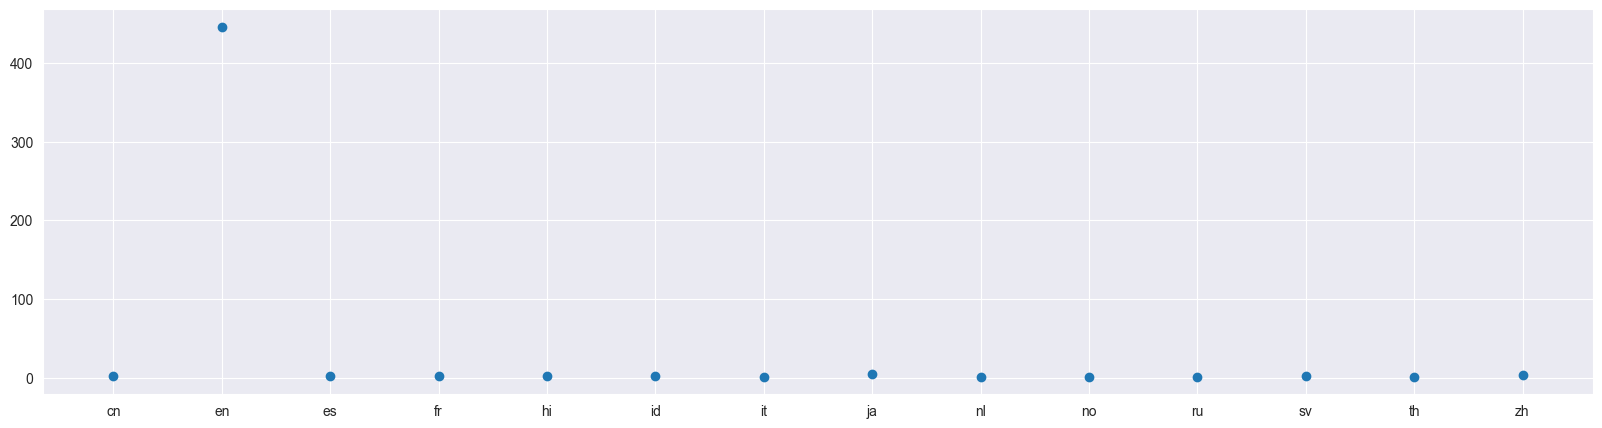

In [90]:
languages = df[['original_language', 'title']].groupby('original_language').count()
fig = plt.scatter(languages.index, languages)


# Związek ocen z budżetem i dochodami
## Budżet

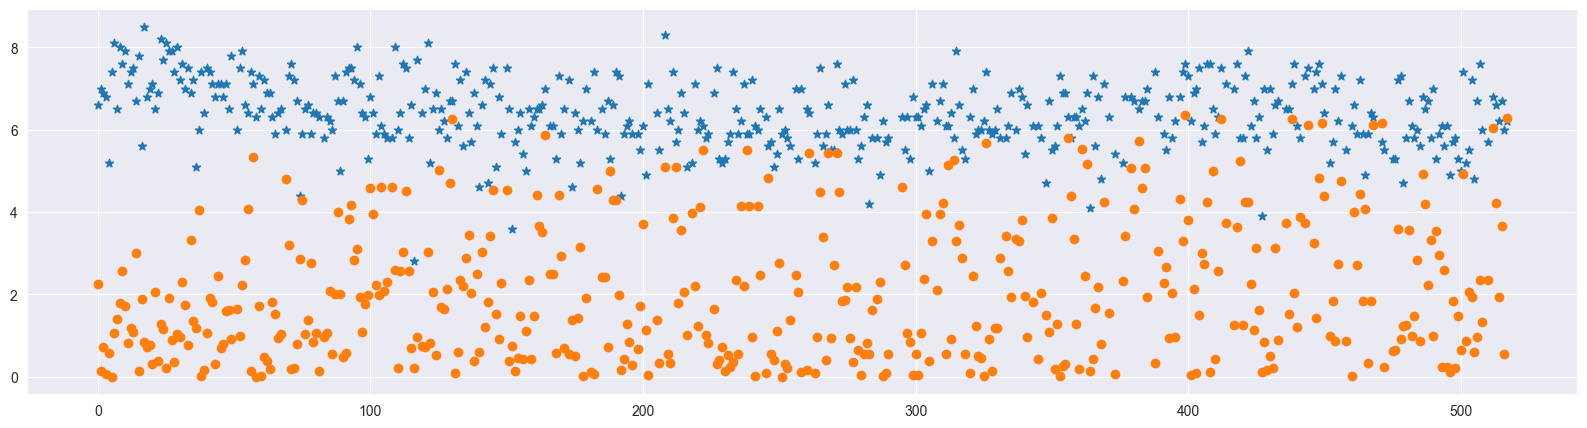

In [127]:
votes = df['vote_average']
budget = (df['adjusted_budget'] / df['adjusted_budget'].max()) * 10
indexes_to_drop = budget.nlargest(10).index
budget = budget.drop(indexes_to_drop)
votes = votes.drop(indexes_to_drop)


plt.scatter(votes.index, votes, marker='*')
plt.scatter(votes.index, budget[votes.index])

# Dochody

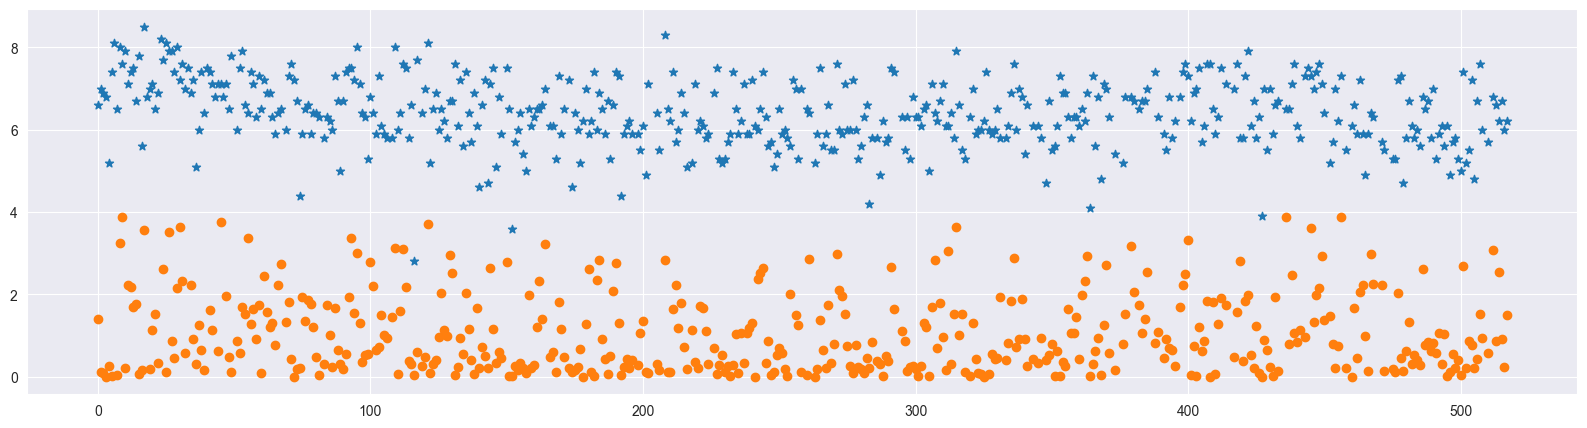

In [94]:
revenue = (df['revenue_adjusted'] / df['revenue_adjusted'].max()) * 10
revenue = revenue.drop(revenue.nlargest(10).index)
plt.scatter(votes.index, votes, marker='*')
plt.scatter(revenue.index, revenue)